<a href="https://colab.research.google.com/github/nrysam/CNN-Car-Parts/blob/main/CNN_based_Car_Part_Identifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#import necessary libraries
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
# Get the dataset
!gdown --id 1oO2A6mmoOYRQsrVXvJUdCCvdiJMvPbK2

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1oO2A6mmoOYRQsrVXvJUdCCvdiJMvPbK2
From (redirected): https://drive.google.com/uc?id=1oO2A6mmoOYRQsrVXvJUdCCvdiJMvPbK2&confirm=t&uuid=2f1e7f45-41ff-4479-87b0-a1ed7c5ef8d8
To: /content/car parts 50.zip
100% 150M/150M [00:01<00:00, 79.8MB/s]


In [3]:
# Unzip the dataset
!unzip -q 'car parts 50.zip' -d dataset

In [4]:
#define the training, validation, testing base directories
train_dir = 'dataset/car parts 50/train'
validation_dir = 'dataset/car parts 50/valid'
test_dir = 'dataset/car parts 50/test'

In [5]:
#Define Target Size, Batch Size, and Class for Generators
TARGET_SIZE = (150,150)
BATCH_SIZE = 32
CLASS_MODE = 'sparse'

In [6]:
def train_val_test_generators(TRAINING_DIR, VALIDATION_DIR, TESTING_DIR):
  """
  Creates the training and validation data generators

  Args:
    TRAINING_DIR (string): directory path containing the training images
    VALIDATION_DIR (string): directory path containing the validation images
    TESTING_DIR (string): directory path containing the testing images
  Returns:
    train_generator, validation_generator, testing_generator: tuple containing the generators
  """
  # Instantiate the ImageDataGenerator class for the training dataset with augmentation
  train_datagen = ImageDataGenerator(
      rescale = 1./255,
      rotation_range = 40,
      width_shift_range=.2,
      height_shift_range=.2,
      shear_range=.2,
      zoom_range=.2,
      horizontal_flip=True,
      fill_mode='nearest'
  )

  # Pass in the appropriate arguments to the flow_from_directory method
  train_generator = train_datagen.flow_from_directory(
      TRAINING_DIR,
      target_size= TARGET_SIZE,
      batch_size = BATCH_SIZE,
      class_mode = CLASS_MODE
  )

  # Instantiate the ImageDataGenerator class for the validation dataset
  validation_datagen = ImageDataGenerator(rescale = 1./255)

  # Pass in the appropriate arguments to the flow_from_directory method
  validation_generator = validation_datagen.flow_from_directory(
      VALIDATION_DIR,
      target_size= TARGET_SIZE,
      batch_size = BATCH_SIZE,
      class_mode = CLASS_MODE
  )

  # Instantiate the ImageDataGenerator class for the testing dataset
  test_datagen = ImageDataGenerator(rescale=1./255)

  # Pass in the appropriate arguments to the flow_from_directory method
  test_generator = test_datagen.flow_from_directory(
      TESTING_DIR,
      target_size= TARGET_SIZE,
      batch_size = BATCH_SIZE,
      class_mode = CLASS_MODE,
      shuffle = False
  )

  return train_generator, validation_generator, test_generator

In [7]:
train_generator, validation_generator, test_generator = train_val_test_generators(train_dir, validation_dir, test_dir)

Found 8739 images belonging to 50 classes.
Found 250 images belonging to 50 classes.
Found 250 images belonging to 50 classes.


In [8]:
#Define the model

def create_model():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(50, activation='softmax')
    ])

    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['acc'])

    return model

In [9]:
from sklearn.utils.class_weight import compute_class_weight

# Calculate class weights for unbalanced training data
classes = np.unique(train_generator.classes)
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=train_generator.classes)
class_weights_dict = dict(zip(classes, class_weights))

In [10]:
#Add callbacks
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'best_model.h5',
    monitor='val_acc',
    verbose=1,
    save_best_only=True,
    mode='max'
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_acc',
    patience=10,
    verbose=1,
    restore_best_weights=True
)

In [11]:
# Save the model
model = create_model()

# Train the model
history = model.fit(train_generator,
                    epochs=100,
                    validation_data=validation_generator,
                    class_weight=class_weights_dict,
                    callbacks=[checkpoint, early_stopping])

Epoch 1/100
274/274 [==============================] - ETA: 0s - loss: 3.8236 - acc: 0.0502
Epoch 1: val_acc improved from -inf to 0.10000, saving model to best_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


274/274 [==============================] - 70s 206ms/step - loss: 3.8236 - acc: 0.0502 - val_loss: 3.6067 - val_acc: 0.1000
Epoch 2/100
274/274 [==============================] - ETA: 0s - loss: 3.5017 - acc: 0.1036
Epoch 2: val_acc improved from 0.10000 to 0.16400, saving model to best_model.h5
274/274 [==============================] - 58s 211ms/step - loss: 3.5017 - acc: 0.1036 - val_loss: 3.0604 - val_acc: 0.1640
Epoch 3/100
274/274 [==============================] - ETA: 0s - loss: 3.0982 - acc: 0.1798
Epoch 3: val_acc improved from 0.16400 to 0.26800, saving model to best_model.h5
274/274 [==============================] - 60s 219ms/step - loss: 3.0982 - acc: 0.1798 - val_loss: 2.7230 - val_acc: 0.2680
Epoch 4/100
274/274 [==============================] - ETA: 0s - loss: 2.8716 - acc: 0.2340
Epoch 4: val_acc improved from 0.26800 to 0.36400, saving model to best_model.h5
274/274 [==============================] - 58s 211ms/step - loss: 2.8716 - acc: 0.2340 - val_loss: 2.3765 - v

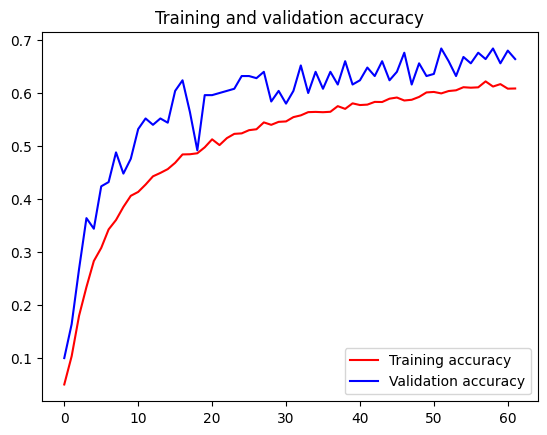

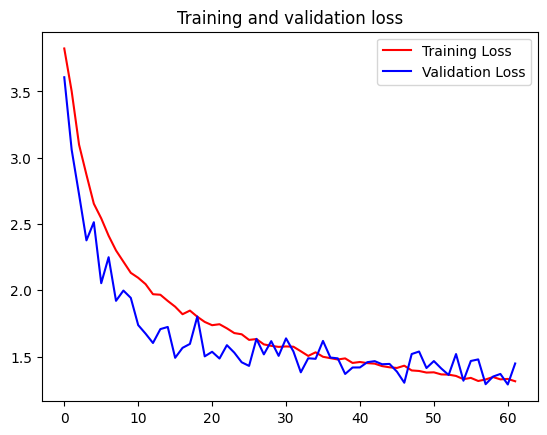

In [12]:
# Plot the chart for accuracy and loss on both training and validation
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

# Accuracy chart
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

# Loss chart
plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [13]:
# Evaluate the Model
import math

test_steps = math.ceil(test_generator.n / test_generator.batch_size)

results = model.evaluate(test_generator, steps=test_steps)
print('test loss, test acc:', results)

8/8 [==============================] - 0s 31ms/step - loss: 1.1439 - acc: 0.6920
test loss, test acc: [1.1439149379730225, 0.6919999718666077]


In [1]:
# Create a prediction from model
predictions = model.predict(test_generator, steps=test_steps)
predicted_classes = np.argmax(predictions, axis=1)

# Define true_classes and class_labels
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Make sure that predicted_classes and true_classes have the same length
if len(predicted_classes) > len(true_classes):
    predicted_classes = predicted_classes[:len(true_classes)]  # Trim predictions to match true_classes length

NameError: name 'model' is not defined

In [ ]:
# Use scikit-learn to generate a detailed classification report
from sklearn.metrics import classification_report

print(classification_report(true_classes, predicted_classes, target_names=class_labels))

In [ ]:
# Add Confusion matrix to visualize the performance across the different classes
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(15,10))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()